# 5510 Final Project: Clustering for Retail Customer Segmentation

For retail stores, gaining insights on their customers is one of the most beneficial ways to improve their business intelligence and profits. Identifying types of customers can be beneficial for marketing campaigns, sales and promotions, and even inventory planning. Because categories of customers are subjective and difficult to create and label with just domain knowledge, this problem is perfectly suited for unsupervised learning techniques. This project explores how customers can be clustered into various distinct subcategories, and what features or characteristics are typical for each cluster. To accomplish this, I use k-means and hierarchical clustering models, refining the number of categories and selecting the most efficient and informative model possible.


In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Data import and cleaning

This project uses data from Kaggle available [here](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data). This dataset records different demographic attributes of customers as well as their spending habits and response to promotional campaigns. I first correct the data type for the 'Dt_Customer' variable and then check for missing values. Because there were only 24 missing values, all in the 'Income' variable, I dropped the rows with missing data and was left with 2,216 observations. There were also three columns at the end of the dataset that were unexplained in the source material, and further analysis revealed that two of these columns had only one value for every observation. Thus, I also dropped these columns from the dataset.

In [2]:
# Import csv file
customer = pd.read_csv('marketing_campaign.csv', sep='\t')

# View dataset
print(customer.info())
customer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# Change Dt_Customer to proper date format
customer['Dt_Customer'] = pd.to_datetime(customer['Dt_Customer'], format='%d-%m-%Y')

# Check values of unknown columns
customer[['Z_CostContact','Z_Revenue','Response']].describe()

,Z_CostContact,Z_Revenue,Response
count,2240.0,2240.0,2240.000000
mean,3.0,11.0,0.149107
std,0.0,0.0,0.356274
min,3.0,11.0,0.000000
25%,3.0,11.0,0.000000
50%,3.0,11.0,0.000000
75%,3.0,11.0,0.000000
max,3.0,11.0,1.000000


In [4]:
# Drop irrelevant columns
customer = customer.drop(['Z_CostContact','Z_Revenue','Response'], axis=1)

# Check for missing values and drop rows
print(customer.isna().sum().sum())
customer = customer.dropna()

24


In [5]:
# Check updated dataset
print(customer.info())
customer.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-null   i

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,8,10,4,7,0,0,0,0,0,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,1,1,2,5,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,8,2,10,4,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,2,0,4,6,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,3,6,5,0,0,0,0,0,0


## Exploratory data analysis

One of the first variables I decided to look at was the 'Income Distribution' column. As shown in the first histogram below, there was one extreme outlier with an annual income of almost \\$700,000, and another seven observations were outliers with a salary around \\$160,000. I decided to remove these outliers since they were a small proportion of the total dataset and they could present problems for the model building later. Conducting a similar analysis with 'Year_Birth', I identified a few outliers born prior to 1900 that I removed. After removing these outliers, there are 2,205 observations in the dataset.

I also compared the number of web visits to the number of web purchases. The distribution of these two variables make sense, with more visits occuring than purchases as some people abandon their online carts or only visit a given retail site to check prices or product availability. Finally, I printed a pair plot and correlation matrix for the primary numeric variables. There aren't many clear relationships between variables based on the pair plots, besides a slight polynomial trend between income and the amount spent in different categories. The correlation matrix confirmed that there isn't any strong correlation between most of the variables, although the variables for the amount spent on various food categories are moderately correlated (< 0.75) with income, which is a relationship I expected to see.

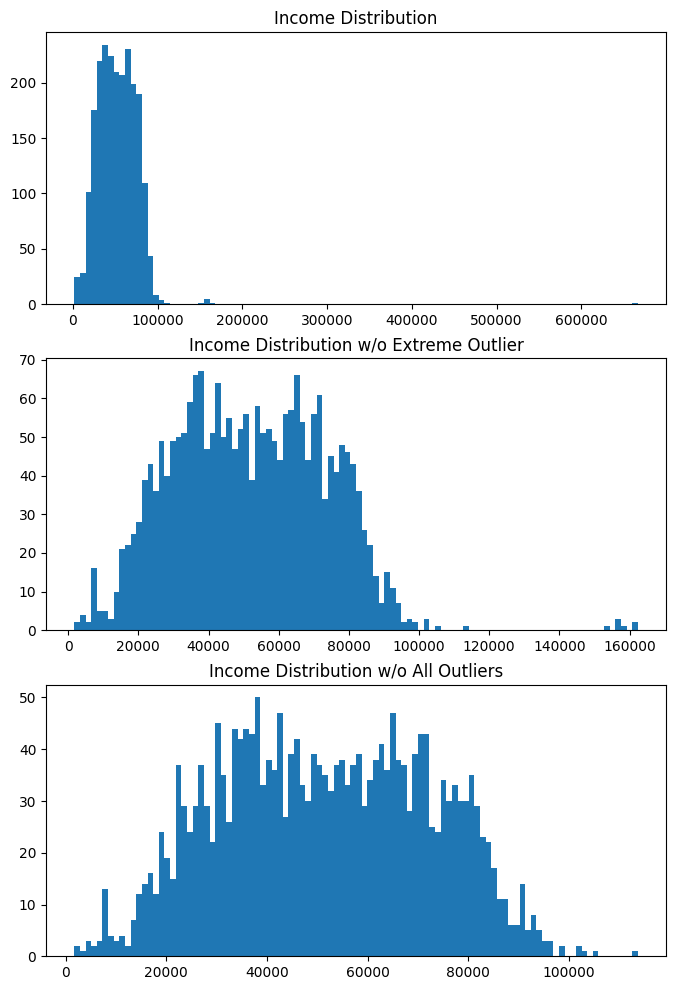

In [6]:
# Testing removing outliers
cust_red = customer[customer['Income']<600000]
cust_red_2 = customer[customer['Income']<120000]

# Income distribution histograms
plt.figure(figsize=(8,12))
plt.title('Income Distribution')
plt.axis(False)
plt.subplot(3,1,1)
plt.hist(customer['Income'], bins=100)
plt.subplot(3,1,2)
plt.hist(cust_red['Income'], bins=100)
plt.title('Income Distribution w/o Extreme Outlier')
plt.subplot(3,1,3)
plt.hist(cust_red_2['Income'], bins=100)
plt.title('Income Distribution w/o All Outliers')
plt.show()

# Remove all outliers
customer = customer[customer['Income']<120000]

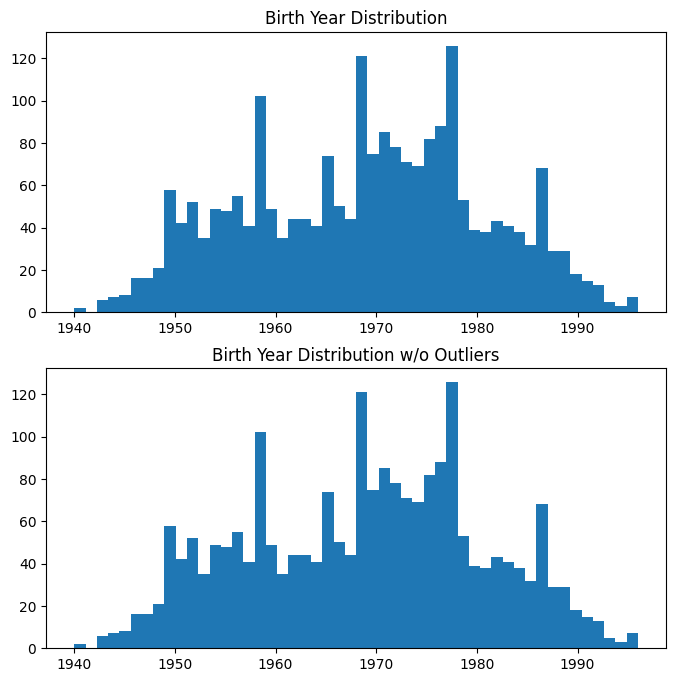

In [27]:
# Testing removing outliers
cust_red = customer[customer['Year_Birth'] > 1900]

# Birth year histogram
plt.figure(figsize=(8,8))
plt.title('Birth Year Distribution')
plt.axis(False)
plt.subplot(2,1,1)
plt.hist(customer['Year_Birth'], bins=50)
plt.subplot(2,1,2)
plt.hist(cust_red['Year_Birth'], bins=50)
plt.title('Birth Year Distribution w/o Outliers')
plt.show()

# Remove outliers
customer = customer[customer['Year_Birth'] > 1900]

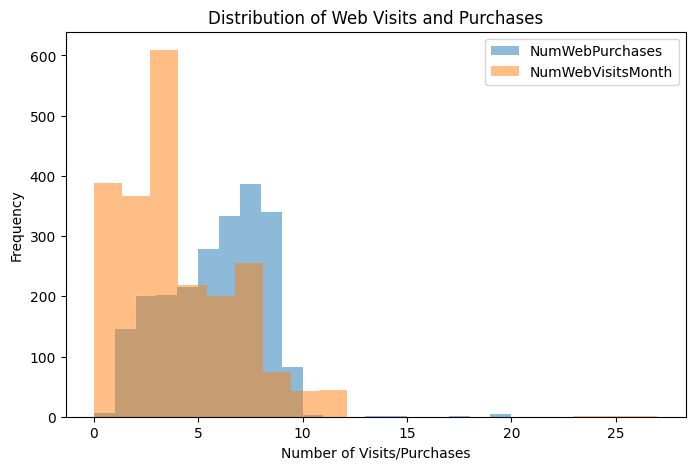

In [8]:
# Web visits and web purchases distribution
plt.figure(figsize=(8,5))
plt.hist(customer['NumWebVisitsMonth'], bins=20, alpha=0.5)
plt.hist(customer['NumWebPurchases'], bins=20, alpha=0.5)
plt.xlabel('Number of Visits/Purchases')
plt.ylabel('Frequency')
plt.title('Distribution of Web Visits and Purchases')
plt.legend(['NumWebPurchases','NumWebVisitsMonth'])
plt.show()

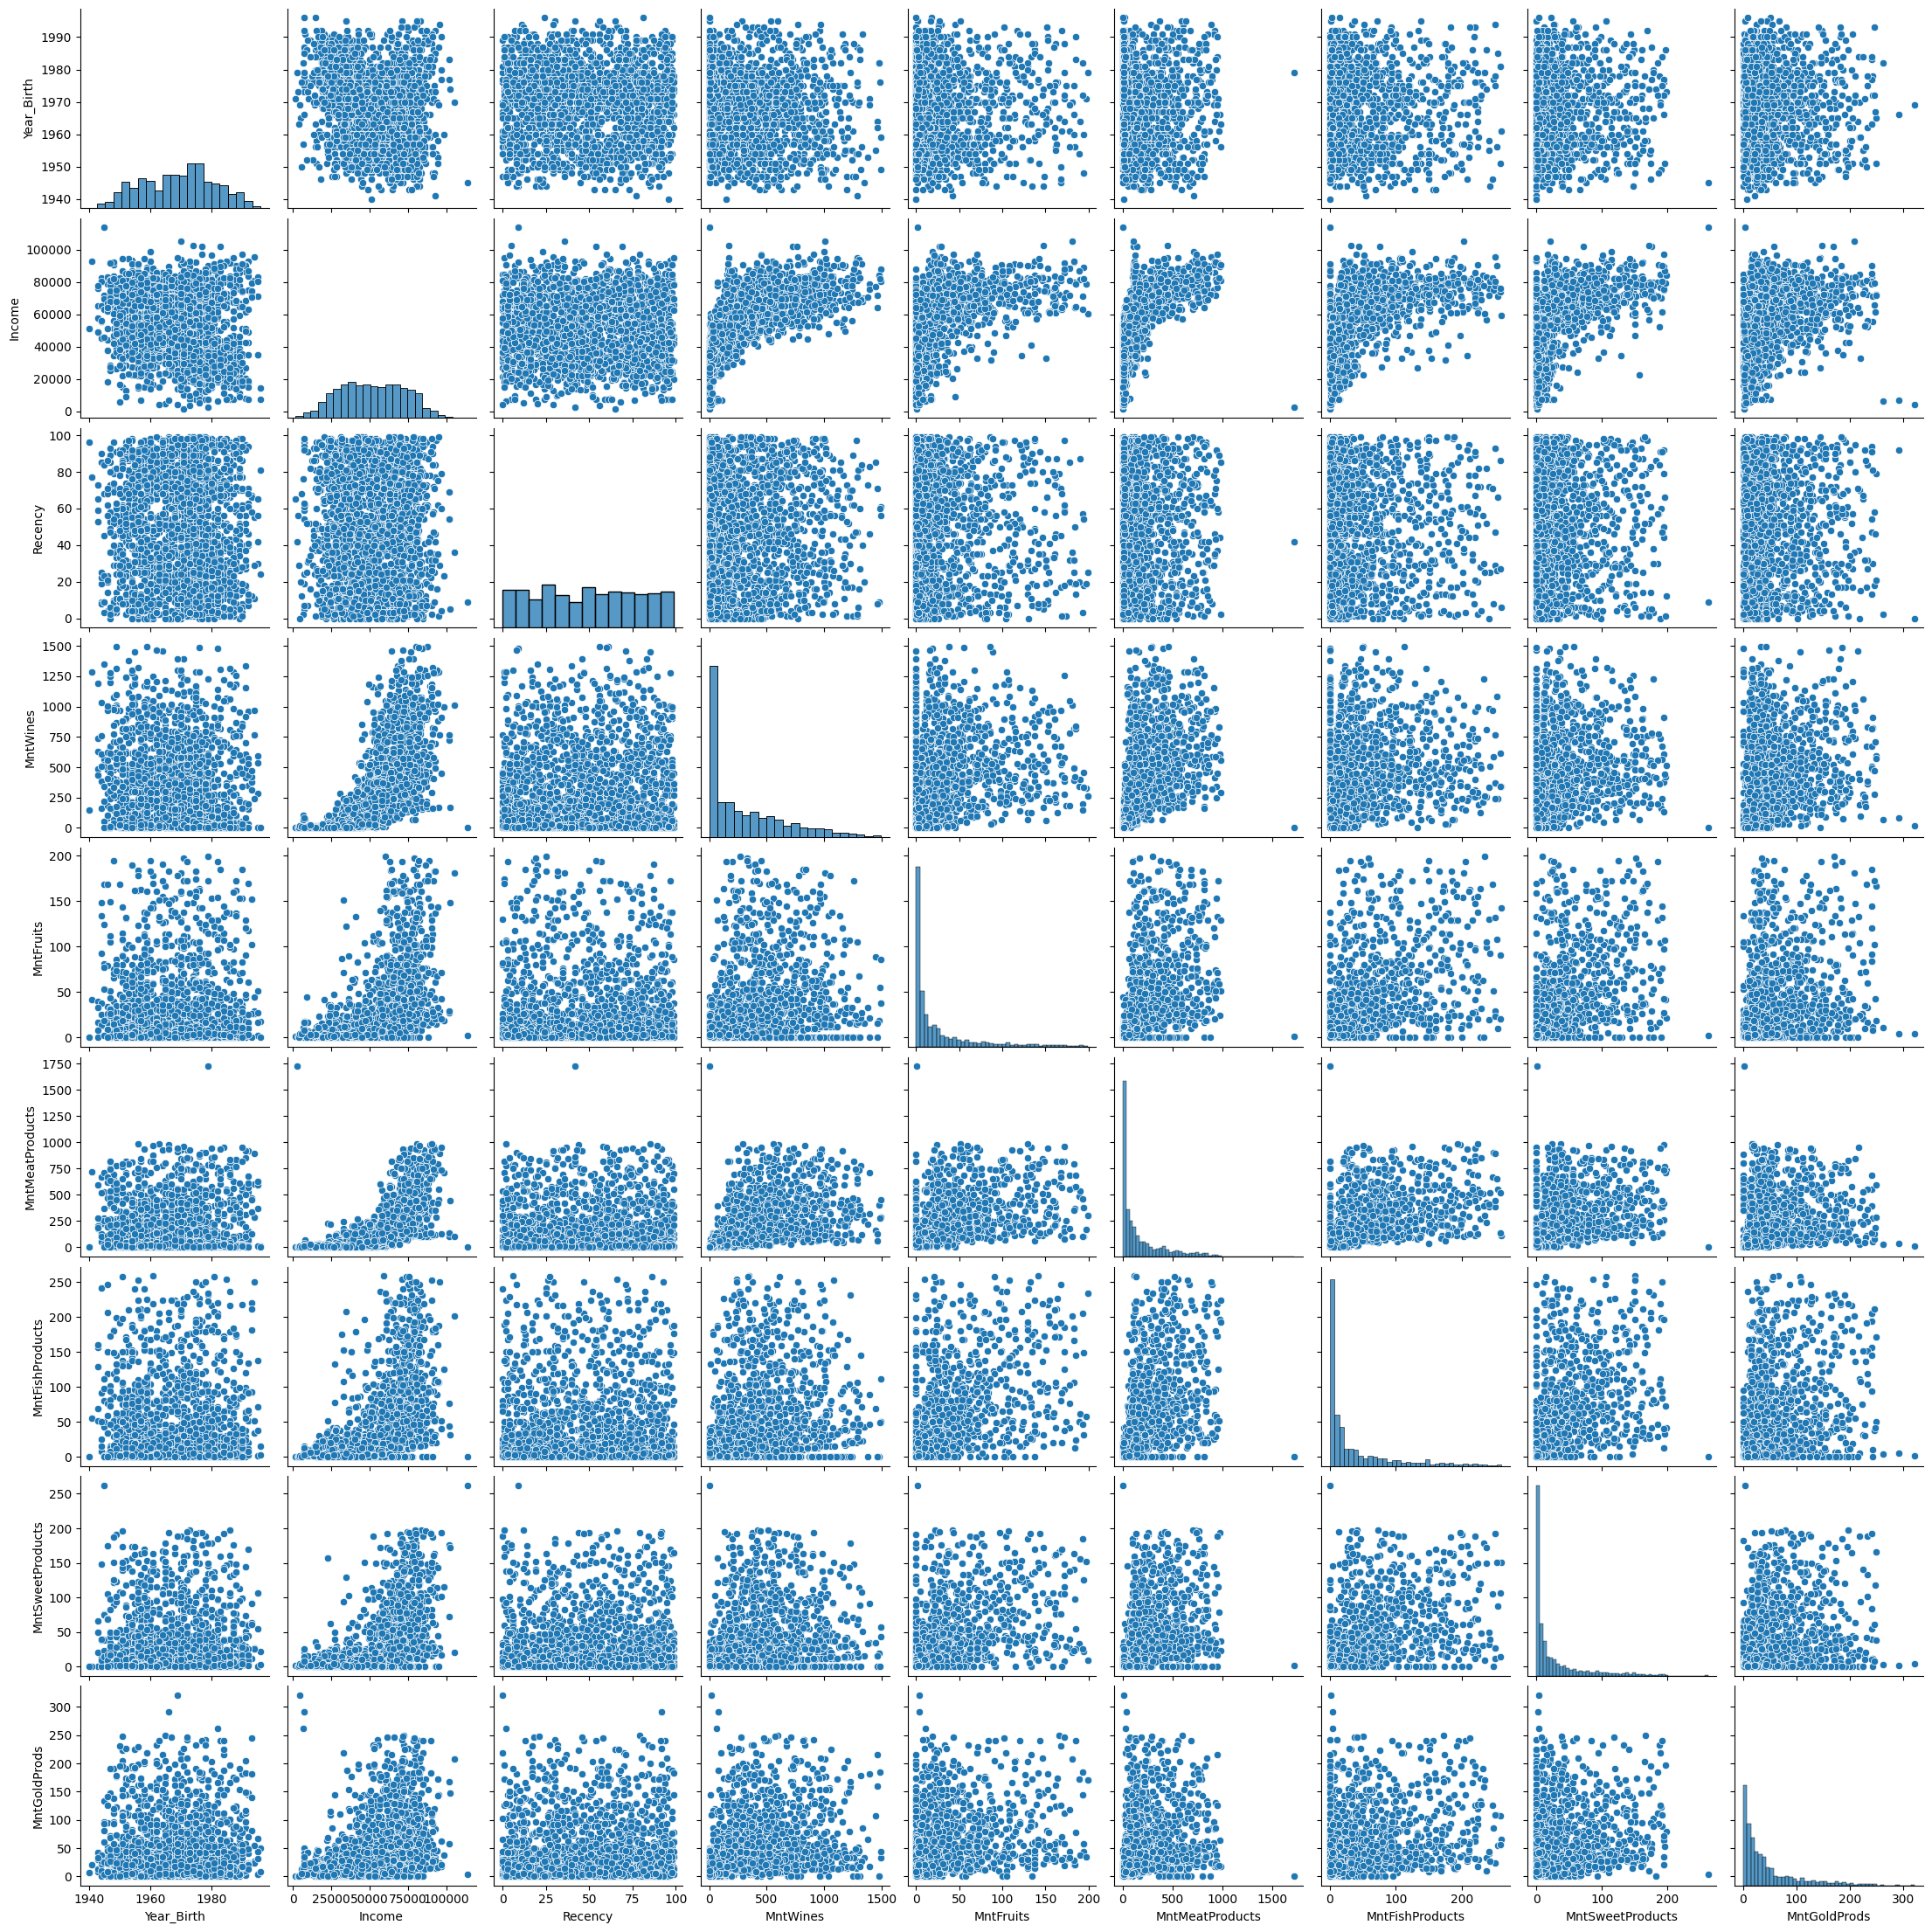

In [9]:
# Pair plots for key numeric variables
pair_columns = ['Year_Birth','Income','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
sns.pairplot(customer[pair_columns])

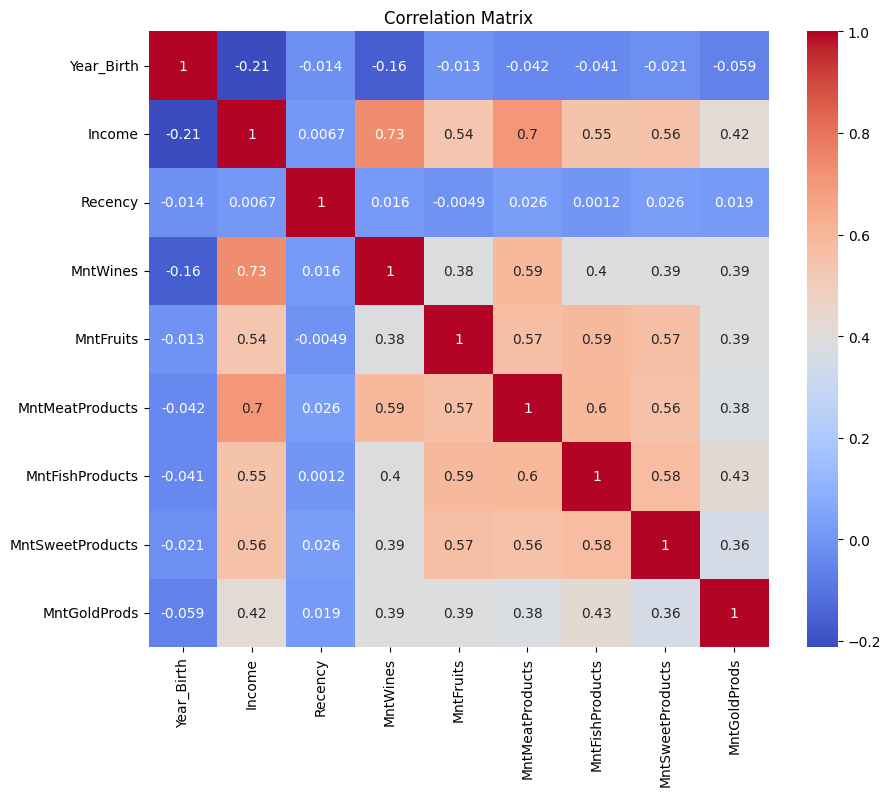

In [28]:
# Correlation matrix for key numeric variables
plt.figure(figsize=(10,8))
corr = customer[pair_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Clustering model building

Before building any models, I begin by standardizing the data to have a mean of zero and a standard deviation of one. For this first step, I only include the numeric variables that I evaluated in the pair plot and confusion matrix above. Without this step, the results of k-means clustering could be skewed by variables with a larger scale than others. However, because there are no predetermined labels to predict or compare performance to, I did not split this data into training and test/validation sets.

### K-means clustering

In [11]:
# Create copy of dataset
customer_copy = customer.copy()

# Convert categorical columns to numeric
customer_copy['Education'] = LabelEncoder().fit_transform(customer_copy['Education'])
customer_copy['Marital_Status'] = LabelEncoder().fit_transform(customer_copy['Marital_Status'])

# Remove binary columns
customer_copy = customer_copy.drop(['Dt_Customer','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Complain'], axis=1)

# Normalize data for clustering
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_copy)

In [12]:
# K-means clustering on full dataset
k_range = range(2,11)
fit = []
sse_score = []
sil_score = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(customer_scaled)
    fit.append(kmeans)
    sse_score.append(kmeans.inertia_)
    sil_score.append(silhouette_score(customer_scaled, kmeans.labels_))

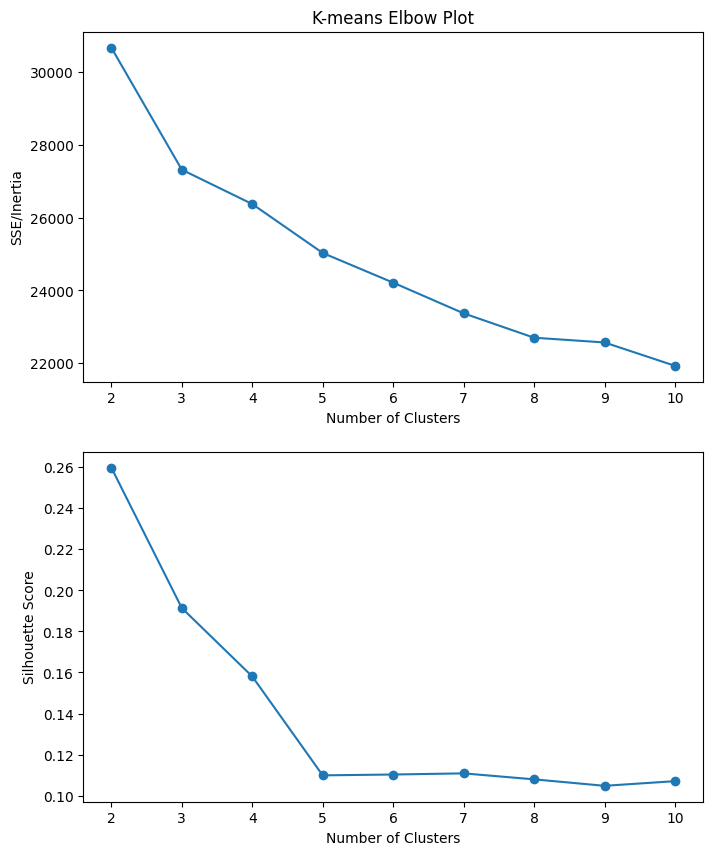

In [13]:
# Elbow plot of k values
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.title('K-means Elbow Plot')
plt.plot(k_range, sse_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE/Inertia')
plt.subplot(2,1,2)
plt.plot(k_range, sil_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Based on the above elbow plot of the sum of squared errors (SSE), also known as the inertia, there is not a clear number of clusters that works for the data as-is. There is a bit of an elbow at two clusters, but it is not very pronounced and thus is not a good choice. When looking at the silhouette score, there is a pronounced elbow at five clusters. Because of the lack of consensus between the two measures, I decided to also try agglomerative clustering to see if it performs better based on the nature of the dataset.




### Agglomerative clustering

In [14]:
# Agglomerative clustering on full dataset
agg_range = range(2,11)
fit = []
score = []

for k in agg_range:
    agg = AgglomerativeClustering(n_clusters=k)
    agg.fit(customer_scaled)
    fit.append(agg)
    score.append(silhouette_score(customer_scaled, agg.labels_))

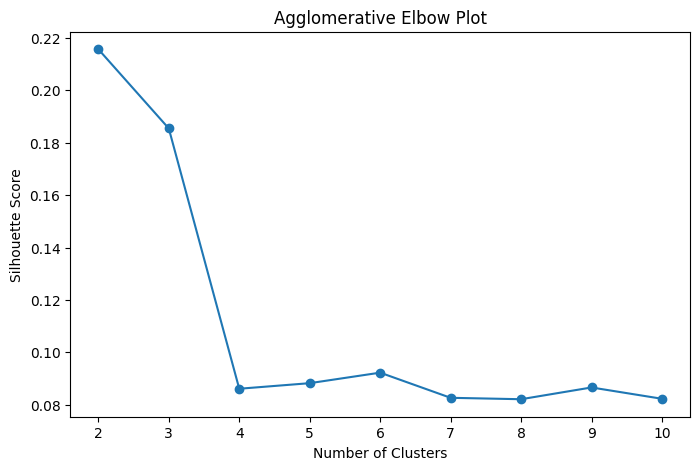

In [15]:
# Elbow plot of k values
plt.figure(figsize=(8,5))
plt.plot(agg_range, score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Agglomerative Elbow Plot')
plt.show()


With agglomerative clustering, there is a clear elbow in the silhouette score at four clusters, so this could be a good model for the data. However, because of the large number of variables included in the model, I also decided to try reducing the dimensionality of the dataset with principle component analysis (PCA) and training the models again to see if there is any improvement in the models.

### Principle component analysis

In [16]:
# Reduce dimensionality with PCA
pca = PCA(n_components='mle')
customer_pca = pca.fit_transform(customer_scaled)
customer_pca = pd.DataFrame(customer_pca)
customer_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3.847552,-0.288443,-1.327854,0.447986,0.425544,0.433912,-0.055613,0.465583,2.143140,-1.114656,-1.243999,0.037643,-1.474734,0.471840,0.515063,0.361202,-0.594989,0.399636
1,-2.279766,0.295375,1.000821,0.907623,0.374221,-1.119412,-0.990453,0.764151,0.106357,0.412068,-0.561499,0.460496,0.249391,0.539248,-0.062699,-0.035912,-0.123428,-0.060422
2,1.968462,-0.253950,0.141384,-0.061447,0.717015,0.316751,-1.393690,-0.718009,-0.290145,-0.950940,0.193437,-0.621797,1.305666,-0.379390,1.017291,0.469197,-0.209005,-0.250758
3,-2.573358,-1.463867,-0.287610,-0.479983,0.602312,1.084384,-0.860660,-0.003106,-0.490703,0.161507,0.108327,-0.103247,0.260939,-0.238707,0.030582,0.089416,-0.088694,-0.003553
4,-0.235183,0.033282,-0.646845,0.367345,-1.742855,1.369338,1.149423,1.418494,0.096346,0.159310,0.486733,-0.408641,0.226010,-0.554664,0.038935,0.836381,-0.496680,-0.280591


In [17]:
# K-means clustering on reduced dataset
k_range = range(2,11)
fit = []
sse_score = []
sil_score = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(customer_pca)
    fit.append(kmeans)
    sse_score.append(kmeans.inertia_)
    sil_score.append(silhouette_score(customer_pca, kmeans.labels_))

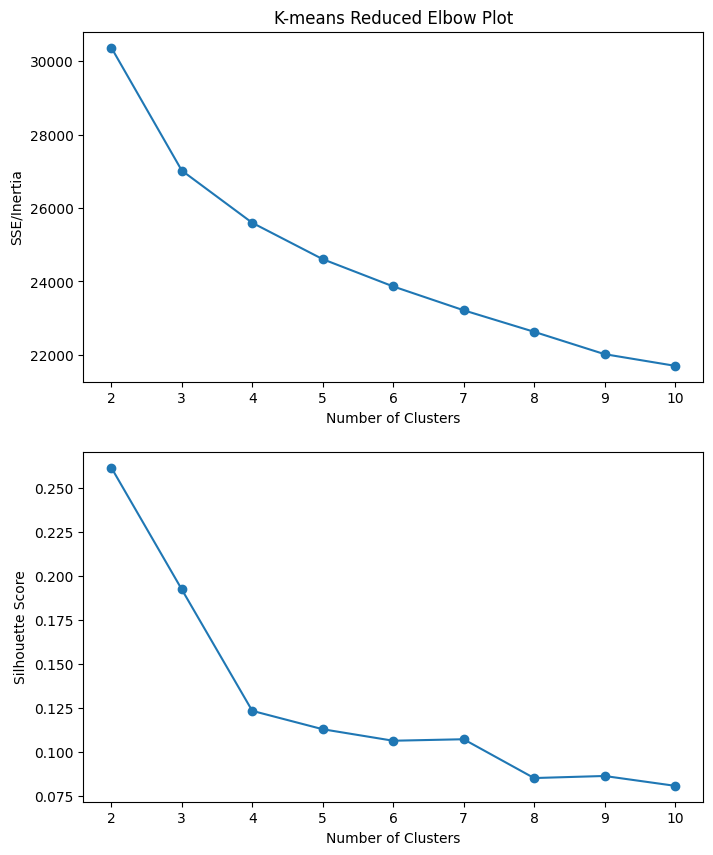

In [18]:
# Elbow plot of k values
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.title('K-means Reduced Elbow Plot')
plt.plot(k_range, sse_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE/Inertia')
plt.subplot(2,1,2)
plt.plot(k_range, sil_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [19]:
# Agglomerative clustering on full dataset
agg_range = range(2,11)
fit = []
score = []

for k in agg_range:
    agg = AgglomerativeClustering(n_clusters=k)
    agg.fit(customer_pca)
    fit.append(agg)
    score.append(silhouette_score(customer_pca, agg.labels_))

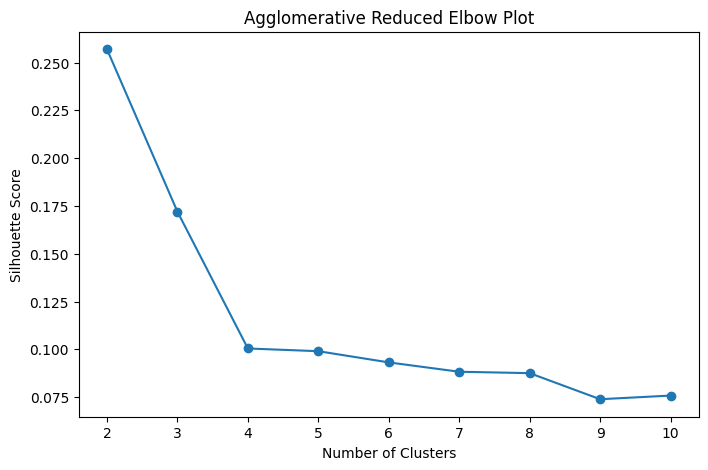

In [20]:
# Elbow plot of k values
plt.figure(figsize=(8,5))
plt.plot(agg_range, score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Agglomerative Reduced Elbow Plot')
plt.show()

## Results and Discussion

Based on the results from the agglomerative clustering on the full dataset and both of the clustering techniques on the reduced dataset from principle component analysis, it appears as though the customers in the dataset can be divided into four clusters. To conclude my analysis, I look at the distribution for key variables across these clusters, using the PCA/agglomerative model results. Based on the bar chart below, there are a relatively even number of customers in each of the four clusters assigned by this model.

In [21]:
# Assign model for discussion
agg_pca_model = AgglomerativeClustering(n_clusters=4)
agg_pca_model.fit(customer_pca)

# Assign clusters to dataset
customer_pca['clusters'] = agg_pca_model.labels_
customer['clusters'] = agg_pca_model.labels_

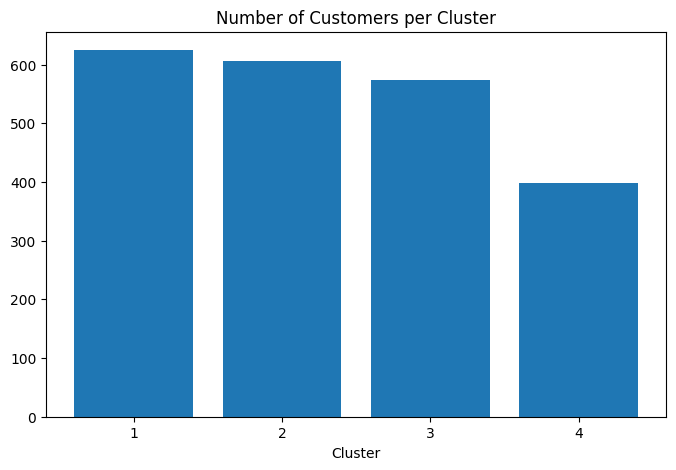

In [22]:
# Check number of customers assigned to each cluster
x = range(4)
y = customer['clusters'].value_counts()

# Create figure
plt.figure(figsize=(8,5))
plt.bar(x,y)
plt.title('Number of Customers per Cluster')
plt.xticks(x, range(1,5))
plt.xlabel('Cluster')
plt.show()

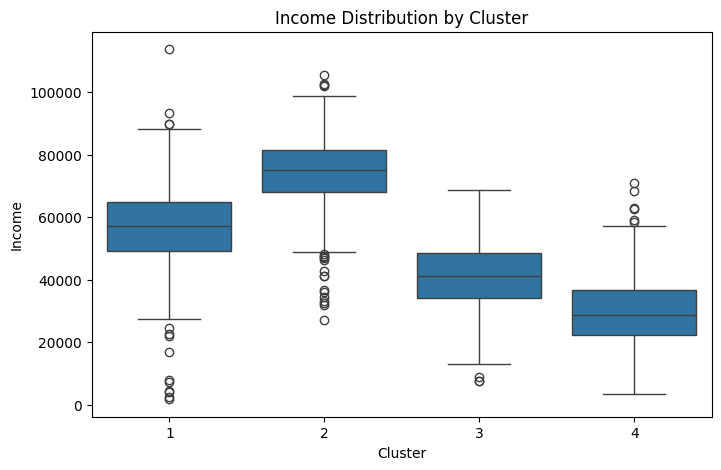

In [23]:
# Boxplot income distribution by cluster
plt.figure(figsize=(8,5))
sns.boxplot(x='clusters', y='Income', data=customer)
plt.xticks(x, range(1,5))
plt.xlabel('Cluster')
plt.title('Income Distribution by Cluster')
plt.show()

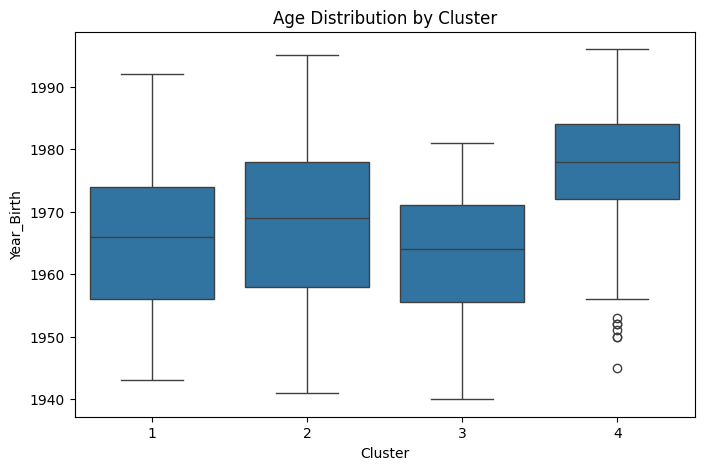

In [24]:
# Boxplot age distribution by cluster
plt.figure(figsize=(8,5))
sns.boxplot(x='clusters', y='Year_Birth', data=customer)
plt.xticks(x, range(1,5))
plt.xlabel('Cluster')
plt.title('Age Distribution by Cluster')
plt.show()

Text(0.5, 1.0, 'Recency by Cluster')

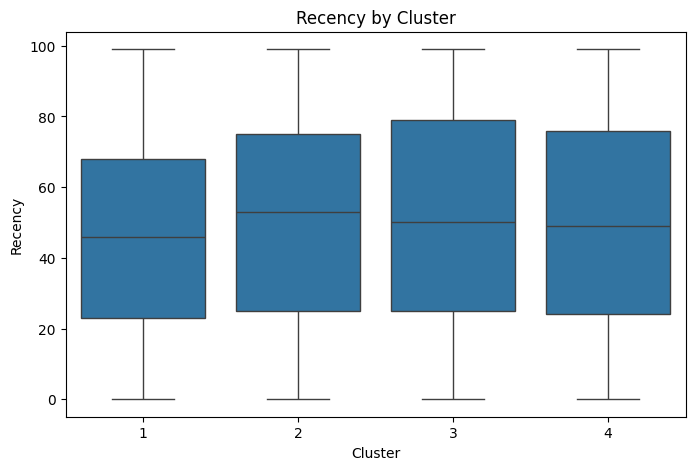

In [25]:
# Boxplot recency by cluster
plt.figure(figsize=(8,5))
sns.boxplot(x='clusters', y='Recency', data=customer)
plt.xticks(x, range(1,5))
plt.xlabel('Cluster')
plt.title('Recency by Cluster')

Text(0.5, 1.0, 'Total Amount Spent by Cluster')

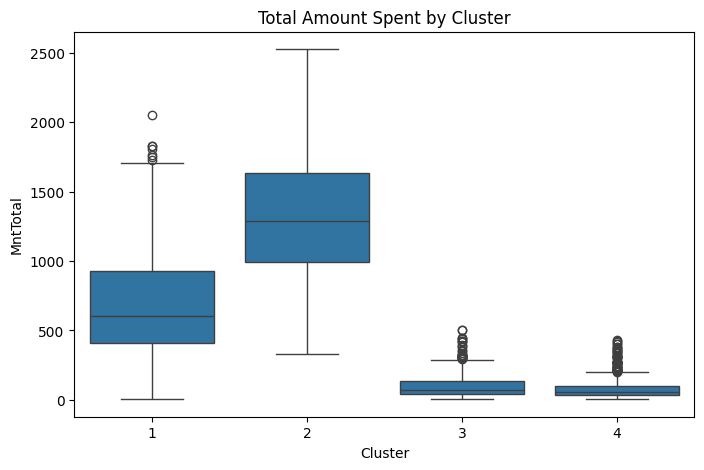

In [26]:
# Calculate total amount spent
amount_list = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
customer['MntTotal'] = customer[amount_list].sum(axis=1)

# Boxplot total amount spent by cluster
plt.figure(figsize=(8,5))
sns.boxplot(x='clusters', y='MntTotal', data=customer)
plt.xticks(x, range(1,5))
plt.xlabel('Cluster')
plt.title('Total Amount Spent by Cluster')

It is clear from the above boxplots that income plays a large role in the classification of customers. This makes sense because one of the driving factors in how consumers choose what, when, and how much to buy is their spending power/how much money they're making. Cluster two in particular appears to be comprised of mostly high-income customers. Most of the clusters are similar in age, but cluster four appears to be comprised of younger consumers who likely have developed different shopping habits. The recency of last visit across clusters is pretty similar, which makes sense because regardless of demographics people need to shop for groceries or other items fairly regularly. However, it does appear that cluster one might be comprised of people who shop slightly more often than the others. The final boxplot supports this theory as cluster one has a higher total spend than three and four, as they likely shop more often. Cluster two's high income distribution is also reflected in the highest spending of the clusters by a large margin.

## Conclusion

There are clearly characteristics that distinguish customers from one another. Based on the models explored in this analysis, the dataset chosen appears to have four distinct types of customers. These customers vary across a range of demographics, based on age, income, and spending habits. For future exploration, it would be interesting to combine the results of this analysis with behavioral or qualitative research to build out more specific profiles of each type of customer. These profiles would be able to provide even more insights in a much more usable manner for a store looking to market toward a specific type of customer.